# Notebook for LSTM VAE without any tricks

# Set up notebook

In [5]:
!nvidia-smi

Fri Jan  3 14:57:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
!pip install sentencepiece

In [7]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
#root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
root_path = '/content/drive/My Drive/Colab Notebooks/Sentence_VAE/'
sys.path.append(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import modules

In [0]:
# import model
#from modules.model import RNN_VAE, word_dropout

# import loss functions
from modules.loss_functions import ELBO_loss, ELBO_lAnneal, ELBO_cAnneal, ELBO_cAnnealFB, cycAnneal

# import utils
from modules.utils import print_generative_reconstruction, print_reconstruction, plot_loss, get_latent_representation, getActiveUnits

In [0]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import optim
from torch.distributions import Categorical

import sentencepiece as spm

import pickle
from IPython.display import Image, display, clear_output
import time

# Load data and SentencePiece model (See respective notebooks to see how they are made)

#### Load pickle with preprocessed data

In [0]:
data_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))

In [11]:
print(f"train formal len: {len(data_dict['train']['formal'])}")
print(f"train informal len: {len(data_dict['train']['informal'])}")
print(f"test formal len: {len(data_dict['test']['formal'])}")
print(f"test informal len: {len(data_dict['test']['informal'])}")

train formal len: 12824
train informal len: 12824
test formal len: 582
test informal len: 582


#### Load SentencePiece model

In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'FRtraintest16000.model')
VOCAB_SIZE = 16000

# Setting up model Model

### model

In [0]:
class RNN_VAE(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, latent_dim, vocab_size, seq_length):
        """
        Initialize model
        :param embedding_dim: int
        :param hidden_dim: int
        :param latent_dim: int
        :param vocab_size: int
        :param seq_length: int
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length  # Why are we not using this?

        self.word_embeddings = nn.Embedding(vocab_size,
                                            embedding_dim)  # Couldn't find any way to send backwards through this, does it exist?

        self.encoder_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_sigma = nn.Linear(hidden_dim, latent_dim)

        self.linear_z_to_h0 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(embedding_dim + latent_dim, hidden_dim, batch_first=True)
        self.decoder_linear = nn.Linear(hidden_dim, vocab_size)

    def encode(self, sentence):
        """
        Encodes the sentence into latent space (note no reparameterization trick here)
        :param sentence: tokenized sentence or batch of tokenized sentences [batch_size, seq_length]
        :return: tensors of batch size containing mu and sigma
        """
        embeds = self.word_embeddings(sentence[:, 1:])
        _, (hidden_state, gate_state) = self.encoder_lstm(embeds)
        mu = self.linear_mu(hidden_state)
        sigma = self.linear_sigma(hidden_state)
        return mu, sigma

    def reparameterize(self, mu, logvar):
        """
        The reparamerization trick
        :param mu: tensor of size batch_size with mu
        :param logvar: tensor of size batch_size with sigma
        :return: tensor of size batch_size with a sample from N(mu, sigma)
        """
        sigma = torch.exp(logvar / 2)
        eps = torch.randn_like(sigma)
        return mu + eps * sigma

    def decode(self, z, sentence):
        """
        Decodes a sentence given the latent space var
        :param z: sample from latent space of size batch_size
        :param sentence: tokenized sentence or batch of tokenized sentences [batch_size, seq_length]
        :return: tensor with logits of size [batch_size, seq_length - 1, vocab_size]
        """
        h_0 = self.linear_z_to_h0(z)
        embeds = self.word_embeddings(sentence[:, :-1])
        embed_z = z.permute(1, 0, 2).expand(-1, self.seq_length - 1, -1)
        embeds_with_z = torch.cat((embeds, embed_z), 2)
        lstm_out, _ = self.decoder_lstm(embeds_with_z, (h_0, torch.zeros_like(h_0)))
        output = self.decoder_linear(lstm_out)
        return output

    def forward(self, sentence):
        """
        Runs the encode, reparameterize and decode in one call
        :param sentence: tokenized sentence or batch of tokenized sentences [batch_size, seq_length]
        :return: tensor with logits of size [batch_size, seq_length - 1, vocab_size] and tensors of size batch_size with
        mu and sigma
        """
        mu, logvar = self.encode(sentence)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, sentence)
        return output, mu, logvar

    def generative_reconstruction(self, sentence):
        """
        Takes in a tokenized sentence, encodes it and iteratively tries to reconstruct it 1 word at a time
        :param sentence: tokenized sentence or batch of tokenized sentences [batch_size, seq_length]
        :return: tensor with the reconstructed tokenized sentence
        """
        mu, logvar = self.encode(sentence)
        z = self.reparameterize(mu, logvar)
        h_0 = self.linear_z_to_h0(z)
        permuted_z = z.permute(1, 0, 2)

        gen_recon_sentence = torch.cuda.LongTensor([[2]], device=next(iter(self.parameters())).device)
        for i in range(sentence.shape[1]):
            gen_embeds = self.word_embeddings(gen_recon_sentence)
            embed_z = permuted_z.expand(-1, i + 1, -1)
            gen_embeds_with_z = torch.cat((gen_embeds, embed_z), 2)
            _, (h_t, c_t) = self.decoder_lstm(gen_embeds_with_z, (h_0, torch.zeros_like(h_0)))
            gen_out = F.softmax(self.decoder_linear(h_t), dim=2)
            cat_dist = Categorical(gen_out)
            next_word = cat_dist.sample()
            next_word = torch.cuda.LongTensor([[next_word]], device=next(iter(self.parameters())).device)
            gen_recon_sentence = torch.cat((gen_recon_sentence, next_word), dim=1)
        return gen_recon_sentence


In [0]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64
BATCH_SIZE = 2048
SEQ_LEN = 12 #padded + EOS + SOS

rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN).cuda()

### Data loader

In [0]:
from torch.utils.data import DataLoader
training_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]
test_data_loader = DataLoader(test_data, batch_size=len(test_data))



### Optimizer

In [0]:
optimizer = optim.Adam(rnn_vae.parameters(),lr= 0.0006)

### Training and test functions

In [0]:
def train(epoch):
    rnn_vae.train()
    epoch_loss = 0
    epoch_bce = 0
    epoch_kld = 0
    for index, sentence in enumerate(train_data_loader):
        sentence = torch.LongTensor(sentence)
        sentence = sentence.cuda()
        optimizer.zero_grad()
        output, mu, log_var = rnn_vae.forward(sentence)
        loss, BCE, KLD = ELBO_loss(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=log_var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_bce += BCE
        epoch_kld += KLD
    epoch_loss /= N_train
    epoch_bce /= N_train
    epoch_kld /= N_train
    return epoch_loss, epoch_bce, epoch_kld


def test(epoch):
    rnn_vae.eval()
    with torch.no_grad(): # No grads needed and we don't want to run out of mem
      epoch_loss = 0
      epoch_bce = 0
      epoch_kld = 0
      for index, sentence in enumerate(test_data_loader):
          sentence = torch.LongTensor(sentence)
          sentence = sentence.cuda()
          output, mu, log_var = rnn_vae.forward(sentence)
          loss, BCE, KLD = ELBO_loss(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=log_var)
          epoch_loss += loss.item()
          epoch_bce += BCE
          epoch_kld += KLD
      epoch_loss /= N_test
      epoch_bce /= N_test
      epoch_kld /= N_test
    return epoch_loss, epoch_bce, epoch_kld

## Training loop

In [0]:
N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)

train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []

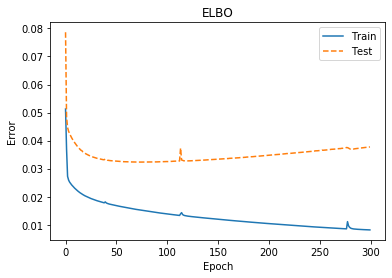

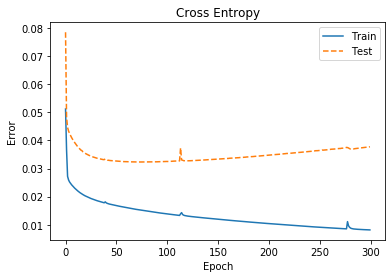

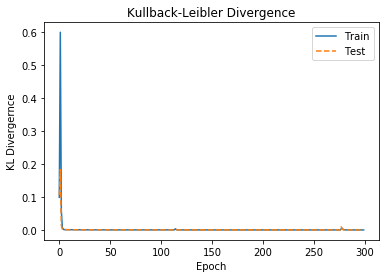

Epoch 299: time: 11.665420293807983
train: loss: 0.008148205257994045 BCE: 0.008148201741278172 KLD: 7.741742592770606e-06
test: loss: 0.03776930779525914 BCE: 0.03776930272579193 KLD: 7.150022611313034e-06


In [0]:
for epoch in range(N_epochs//2):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

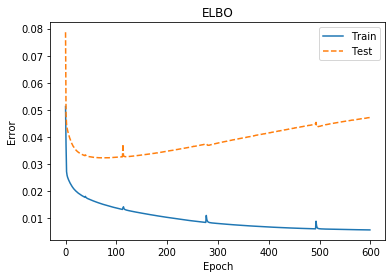

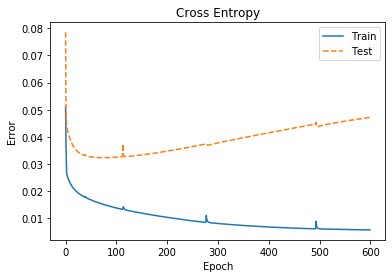

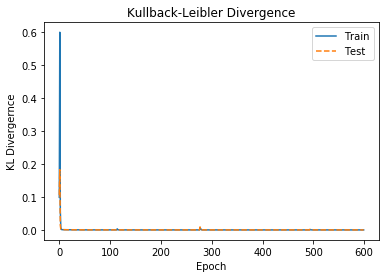

Epoch 599: time: 11.686094760894775
train: loss: 0.005765970096838006 BCE: 0.005765964277088642 KLD: 1.0102690794155933e-05
test: loss: 0.04720543012586246 BCE: 0.047205422073602676 KLD: 1.1346875908202492e-05


In [0]:
for epoch in range(N_epochs//2, N_epochs):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

#### save model

In [0]:
torch.save(rnn_vae.state_dict(), root_path + "trained_models/" + "basline_lstm_vae.pt")

#### Optional load model

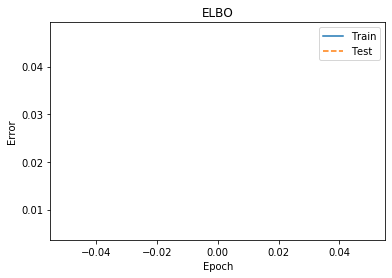

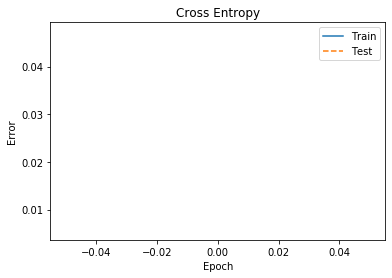

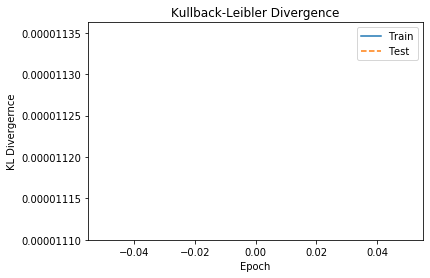

Epoch 0: time: 3.7578907012939453
train: loss: 0.005727290140414937 BCE: 0.005727284122258425 KLD: 1.1111865205748472e-05
test: loss: 0.04720225121147444 BCE: 0.04720224067568779 KLD: 1.1350664863130078e-05


In [24]:


N_epochs = 600
N_train = len(training_data)
N_test = len(test_data)
train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []

rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN).cuda()

rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "basline_lstm_vae.pt"))

for epoch in range(1):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)


#rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "baseline_lstm_vae.pt"))

# Model evaluation

#### ELBO, CBE and KL Divergence of trained model

In [25]:
print(f"ELBO \nTrain: {train_loss_arr[-1]} Test: {test_loss_arr[-1]}")
print(f"Cross Entropy \nTrain: {train_bce_arr[-1]} Test: {test_bce_arr[-1]}")
print(f"KL Divergence \nTrain: {train_kld_arr[-1]} Test: {test_kld_arr[-1]}")

ELBO 
Train: 0.005727290140414937 Test: 0.04720225121147444
Cross Entropy 
Train: 0.005727284122258425 Test: 0.04720224067568779
KL Divergence 
Train: 1.1111865205748472e-05 Test: 1.1350664863130078e-05


In [26]:
active_units, test_vars = getActiveUnits(rnn_vae, test_data_loader, delta=0.02)
print(f"Active units: {active_units.cpu().numpy()}")
print(f"Variances: \n{test_vars.cpu().detach().numpy()}")

Active units: 0
Variances: 
[[1.21234919e-07 1.61696249e-07 8.04218772e-08 1.28926175e-07
  7.38187467e-08 1.26355104e-07 1.19149682e-07 4.14935414e-07
  4.94497215e-07 1.11551046e-07 7.88719063e-08 2.50060282e-07
  4.51625908e-07 1.58654856e-07 4.99029653e-08 1.19775137e-07
  2.41262597e-07 7.21357409e-08 7.48896980e-07 1.93017144e-07
  2.37000677e-07 1.23482849e-07 5.14607983e-08 1.73513271e-07
  1.27138634e-07 2.16838160e-07 8.78627233e-08 1.68596550e-08
  2.36874683e-07 1.70509281e-07 3.33000862e-08 2.20135206e-07
  4.14853275e-07 7.19173954e-07 1.90470331e-07 1.26563279e-07
  6.51412790e-08 5.68455562e-07 1.29127187e-07 1.77695782e-07
  6.48990977e-07 1.47768773e-07 2.82127104e-07 6.10376162e-07
  3.20292401e-07 1.27647493e-08 1.79770964e-07 3.28733847e-07
  1.68545824e-07 1.42814599e-07 7.87661989e-08 2.11642657e-07
  7.27198497e-08 2.95817216e-07 4.79264344e-08 4.54919871e-07
  1.33304880e-07 1.60660889e-07 2.81814305e-08 1.93313610e-07
  2.88358876e-07 4.83235709e-08 2.51272514

#### reconstructing sentences from training set

In [0]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=train_data_loader)
  print('*******')

Real sentence: did she give you something?
Generated sentence: you will get to know you.... if".

*******
Real sentence: i don't really like them big.
Generated sentence: are you discussing s&m?

*******
Real sentence: a guy would do what you allow him to.
Generated sentence: newer questions get more activity on yahoo!

*******
Real sentence: you are a fool for staying... not leaving.
Generated sentence: fool me once shame on you.

*******
Real sentence: yes if u love them very very much
Generated sentence: you cant mix it up a buddy.

*******
Real sentence: no, stay with him forever and ever.
Generated sentence: care for him and tell her.

*******
Real sentence: ask her why she does what she is doing.
Generated sentence: i have no experience choosing a partner.

*******
Real sentence: i wouldnt feel bad about it thought.
Generated sentence: close and lock your bedroom door.

*******
Real sentence: if that seems to impersonal ask.
Generated sentence: so yees it will be awkward.

******

#### reconstructing sentences from test set

In [0]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=test_data_loader)
  print('*******')

Real sentence: are you posing a rhetorical question?
Generated sentence: do not go look for the money.

*******
Real sentence: i do not intend to be mean.
Generated sentence: he should be alright if not, leave.

*******
Real sentence: ask him if you should go see a doctor.
Generated sentence: just act naturally and enjoy yourself.

*******
Real sentence: also, i would like to try again.
Generated sentence: don't explain when speaking from both.

*******
Real sentence: women are coomplicated.
Generated sentence: i would like to go to bed with you..

*******
Real sentence: doing that does sound rather feminine.
Generated sentence: which types of flirting happen at all looking girls

*******
Real sentence: do i desire to be in love?
Generated sentence: what about a cd burner?

*******
Real sentence: that is if you truly adore them.
Generated sentence: like wat is the rule towards that?

*******
Real sentence: you should never allow a man to mistreat you.
Generated sentence: there is nothi